In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from scipy import integrate

In [2]:
#Define parameters from paper
alpha_ptc = 0.024
gamma_p = 0.006
gamma_c = 0.1067
K_h = 1.8124
k_off = 0.9157
k_on = K_h * k_off
K_p = 0.01
n_p = 1.3007
alpha_f = 0.7610
gamma_f = 0.002
alpha_a = 1.9996
alpha_R2 = 0.00326
alpha_R3 = 0.0315
gamma_a = 0.02
gamma_R = 0.002
K_gli = 0.1501
alpha_GBS = 0.0022
alpha_GBS0 = 1.384e-4
D_diff = 52.3942
alpha_HH = 0.4898
gamma_H = 7.644e-6
beta = 16
m = 2.5595
beta_fl = 2.3797
t_dr = 30

In [3]:
def create_d_matrix(n):
    h = 1/(n-1)
    D = -2*np.identity(n) 
    for i in range(n-1):
        D[i+1, i] = 1
        D[i, i+1] = 1       
    D[n-1] = 0
    D[0,1] = 2    
    return D

In [4]:
def AF(t):
    if t < t_dr:
        return alpha_f
    elif t >= t_dr and t < 2.5*t_dr:
        return alpha_f*(2.5*t_dr - t)
    else:
        return 0
        
def update_H(H, P, C, t, D):
    n = len(H)
    h = 1/(n-1)
    alpha = (D_diff*t)/(h**2)
    M = H - (gamma_H*H) - (k_on*H*P) + (k_off*C)
    M[0] += (alpha_HH/D_diff)*2*h*alpha
    Differentiation_Matrix = D
    A = np.identity(n) - alpha*Differentiation_Matrix
    future_H = np.linalg.solve(A, M)
    future_H[future_H < 0] = 0
    return future_H

def phi_AR(A,R):
    num = A**2 + K_gli*A
    den = A**2 + 2*K_gli*A + 2*K_gli*R + 2*A*R + R**2 + K_gli**2
    return num/den


def update_P(H, A, P, R, C, t):
    phi = phi_AR(A,R)
    n = len(H)
    delta = ((alpha_ptc)*np.ones(n)) + ((alpha_ptc)*beta*phi) - (gamma_p*P) - (k_on*H*P) + (k_off*C)
    future_P = P + delta*t
    future_P[future_P < 0] = 0
    return future_P
    
def update_C(H, P, C, t):
    n = len(H)
    delta = (k_on*H*P) - (k_off*C) - (gamma_c*C)
    future_C = C + delta*t
    future_C[future_C < 0] = 0      
    return future_C

def update_F2(A,R,P,F2,t, elapsed_time):
    af = AF(elapsed_time)
    phi = phi_AR(A,R)
    g1 = af*(1+beta_fl*phi)
    g2 = alpha_a*((K_p**n_p)/((K_p**n_p)+(P**n_p))) + alpha_R2 + gamma_f
    delta = (g1 - g2*F2)
    future_F2 = F2 + delta*t
    future_F2[future_F2 < 0] = 0
    return future_F2

def update_F3(P,F3,t, elapsed_time):
    af = AF(elapsed_time)
    delta = af - (alpha_a*((K_p**n_p)/((K_p**n_p)+(P**n_p))) + alpha_R3 + gamma_f)*F3
    future_F3 = F3 + delta*t
    future_F3[future_F3 < 0] = 0
    return future_F3   

def update_R(F2, F3, R, t):
    delta = alpha_R2*F2 + alpha_R3*F3 - gamma_R*R
    future_R = R + delta*t
    future_R[future_R < 0] = 0
    return future_R
    
def update_A(P, F2, F3, A, t):
    delta = alpha_a*((K_p**n_p)/((K_p**n_p)+(P**n_p)))*(F2+F3) - gamma_a*A
    future_A = A + delta*t
    future_A[future_A < 0] = 0
    return future_A

def update_S(R, A, S, t):
    phi = phi_AR(A,R)
    n = len(R)
    delta = (alpha_GBS0*np.ones(n)) + (alpha_GBS*phi) #*1000
    future_S = S + delta*t
    future_S[future_S < 0] = 0
    return future_S

In [7]:
def integrate_solution(final_time, time_step, n):
    H = np.zeros(n)
    C = np.zeros(n)
    S = np.zeros(n)
    F2 = 125.156*np.ones(n)
    F3 = 22.172*np.ones(n)
    A = 6.058*np.ones(n)
    P = 4.0124*np.ones(n)
    R = 551.562*np.ones(n)
    time = 0
    Hs = H[0]
    D = create_d_matrix(n)
    hrs = int(np.floor( final_time / 60)); #number of hours we will simulate over
    
    #make arrays to hold the values of each protein at each grid point at each hour
    H_vals = np.zeros((hrs+1,n));
    H_vals[0] = H; #initialize at t=0
    C_vals = np.zeros((hrs+1,n));
    C_vals[0] = C; #initialize at t=0
    S_vals = []; #need this to be a list since we are appending at every half-min
    S_vals.append(S); #initialize at t=0
    P_vals = np.zeros((hrs+1,n));
    P_vals[0] = P; #initialize at t=0
    R_vals = np.zeros((hrs+1,n));
    R_vals[0] = R; #initialize at t=0
    F2_vals = np.zeros((hrs+1,n));
    F2_vals[0] = F2; #initialize at t=0
    F3_vals = np.zeros((hrs+1,n));
    F3_vals[0] = F3; #initialize at t=0
    A_vals = np.zeros((hrs+1,n));
    A_vals[0] = A; #initialize at t=0
    
    steps_each_hr = 60 / time_step + 1;
    step_each_half_min = 0.5 / time_step + 1;
    steps = 0;
    
    while time<final_time:
#         print(time)
        #calculate the updates for each protein
        H_upd = update_H(H, P, C, time_step, D);
        P_upd = update_P(H, A, P, R, C, time_step);
        C_upd = update_C(H, P, C, time_step);
        F2_upd = update_F2(A,R,P,F2,time_step, time/60);
        F3_upd = update_F3(P,F3,time_step, time/60);
        R_upd = update_R(F2, F3, R, time_step);
        A_upd = update_A(P, F2, F3, A, time_step);
        S_upd = update_S(R, A, S, time_step);
        #reassign each protein to new concentrations
        H = H_upd;
        P = P_upd;
        C = C_upd;
        F2 = F2_upd;
        F3 = F3_upd;
        R = R_upd;
        A = A_upd;
        S = S_upd;
        
        time += time_step #increment total time
        steps +=1;
        if steps % step_each_half_min == 0:
            S_vals.append(S);
        if steps == steps_each_hr : #we've reached an hour
            #store protein concentrations at each grid point for this hour
            index = int(time / 60);
            print("Index to insert at:", index);
            H_vals[index] = H;
            P_vals[index] = P;
            C_vals[index] = C;
            F2_vals[index] = F2;
            F3_vals[index] = F3;
            R_vals[index] = R;
            A_vals[index] = A;
            steps = 0; #reinitialize steps
            
    #add results from last time step to matrices
    H_vals[-1] = H;
    P_vals[-1] = P;
    C_vals[-1] = C;
    F2_vals[-1] = F2;
    F3_vals[-1] = F3;
    R_vals[-1] = R;
    A_vals[-1] = A;
    S_vals.append(S);
        
        
    return H_vals, P_vals, C_vals, R_vals, S_vals, F2_vals, F3_vals, A_vals;

In [8]:
from time import clock

c = clock();
hrs_to_sim = 100;
time_step = 0.01;
H, P, C, R, S, F2, F3, A = integrate_solution(hrs_to_sim*60, time_step, 500);
stop = clock();

print("Time: {0} min".format( (stop-c)/60 ) );

Index to insert at: 1
Index to insert at: 2
Index to insert at: 3
Index to insert at: 4
Index to insert at: 5
Index to insert at: 6
Index to insert at: 7
Index to insert at: 8
Index to insert at: 9
Index to insert at: 10
Index to insert at: 11
Index to insert at: 12
Index to insert at: 13
Index to insert at: 14
Index to insert at: 15
Index to insert at: 16
Index to insert at: 17
Index to insert at: 18
Index to insert at: 19
Index to insert at: 20
Index to insert at: 21
Index to insert at: 22
Index to insert at: 23
Index to insert at: 24
Index to insert at: 25
Index to insert at: 26
Index to insert at: 27
Index to insert at: 28
Index to insert at: 29
Index to insert at: 30
Index to insert at: 31
Index to insert at: 32
Index to insert at: 33
Index to insert at: 34
Index to insert at: 35
Index to insert at: 36
Index to insert at: 37
Index to insert at: 38
Index to insert at: 39
Index to insert at: 40
Index to insert at: 41
Index to insert at: 42
Index to insert at: 43
Index to insert at: 

In [9]:
prots = [H, P, C, R, S, F2, F3, A];
names = ["H", "P", "C", "R", "S", "F2", "F3", "A"];

for i, p in enumerate(prots):
    file_name = "{0}_100hr_sim.csv".format(names[i]);
    np.savetxt(file_name, p, delimiter=",");

In [10]:
def normalize_S(S):
    normed_S = S.copy()
    normed_S = normed_S/np.max(normed_S)
    normed_S = normed_S - np.min(normed_S)
    return normed_S

In [12]:
len(S)

11700

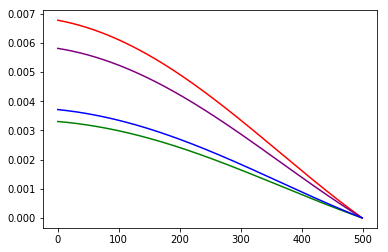

In [19]:
# plt.plot(normalize_S(S[1]))
# plt.plot(normalize_S(S[2]))

plt.plot(normalize_S(S[2000]), color='g')
plt.plot(normalize_S(S[5000]), color='r')
plt.plot(normalize_S(S[7000]), color = 'purple')
plt.plot(normalize_S(S[11698]), color='b')
plt.show() # this doesn't make sense? Product of the normalization I guess?